In [ ]:
! pip -q install bitsandbytes

In [4]:
# Colab setup
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'LLM-Project')
os.chdir(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
import torch

model_id = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

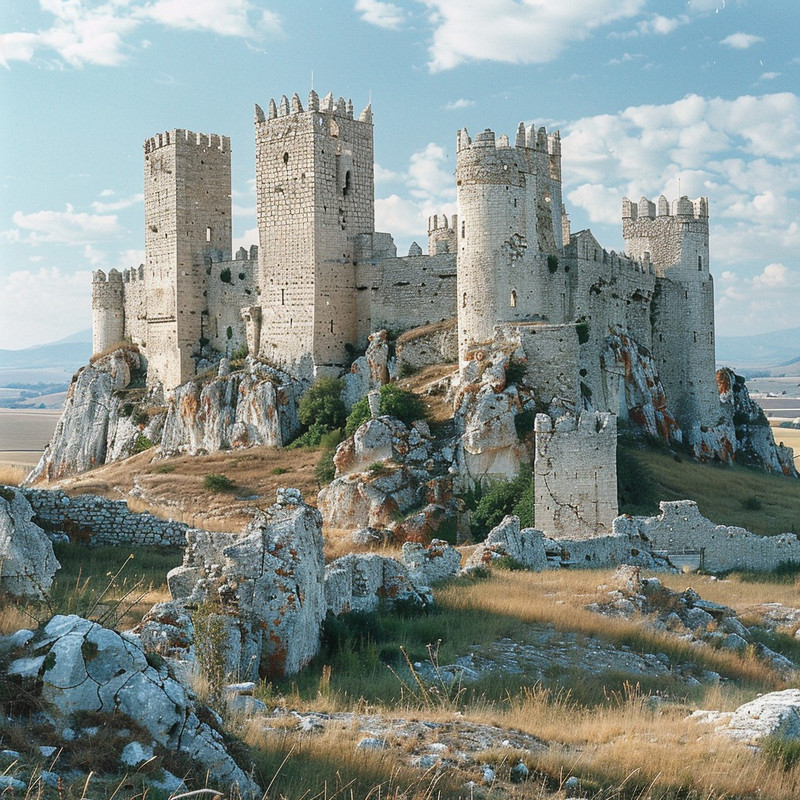

In [ ]:
from PIL import Image

!wget "https://i.postimg.cc/44hZvX9K/majestic-medieval-castle-stockcake.jpg" -O sample.png
image = Image.open("sample.png")
image

In [ ]:
prompt = "<image>\nWhat is happening in this image?"

inputs = processor(image, prompt, return_tensors="pt").to(model.device)

output = model.generate(**inputs, max_new_tokens=150)

response = processor.decode(output[0], skip_special_tokens=True)
print("LLaVA Response:", response)

LLaVA Response: 
What is happening in this image?
In this image, a group of old, large, and beautiful stone buildings are situated on a hill. The buildings are made of stone and have a castle-like appearance. The scene is set against a backdrop of a blue sky, which adds to the overall beauty of the image.


In [8]:
def convert_dict_to_list(path):
    import json
    with open(path) as f:
        data = json.load(f)
    return list(data.values())

In [13]:
from datasets import load_dataset
from datasets import Features, Value, Image


features = Features({
    # "question": Value("string"),
    # "answer": Value("string"),
     "key_frames": {
        "__dict__": {
            "key_object_infos": {
                "__dict__": {
                    "__dict__": {
                        "Category": Value("string"),
                        "Status": Value("string"),
                        "Visual_description": Value("string"),
                        "2d_bbox": Sequence(Value("float32")),
                    }
                }
            }
        }
    },
    "image_paths": {
        "CAM_FRONT": Image(),
        "CAM_FRONT_LEFT": Image(),
        "CAM_FRONT_RIGHT": Image(),
        "CAM_BACK": Image(),
        "CAM_BACK_LEFT": Image(),
        "CAM_BACK_RIGHT": Image()
    },
})


dataset = load_dataset("json", data_files="data/QA_dataset_nus/v1_0_train_nus.json", features=features)

print(dataset)


TypeError: expected str, bytes or os.PathLike object, not list

In [17]:
import json
from datasets import Dataset, Features, Value, Image

with open("data/QA_dataset_nus/v1_0_train_nus.json", "r") as f:
    nested_json = json.load(f)

records = []
for scene_token, scene_data in nested_json.items():
    for frame_token, frame_data in scene_data["key_frames"].items():
        image_path = frame_data["image_paths"].get("CAM_FRONT", None)
        for qa_type, qa_list in frame_data["QA"].items():
            for qa in qa_list:
                records.append({
                    "scene_token": scene_token,
                    "frame_token": frame_token,
                    "qa_type": qa_type,
                    "question": qa["Q"],
                    "answer": qa["A"],
                    "image": image_path
                })

# Define features for Hugging Face dataset
features = Features({
    "scene_token": Value("string"),
    "frame_token": Value("string"),
    "qa_type": Value("string"),
    "question": Value("string"),
    "answer": Value("string"),
    "image": Image()
})

dataset = Dataset.from_list(records, features=features)


In [20]:
dataset

Dataset({
    features: ['scene_token', 'frame_token', 'qa_type', 'question', 'answer', 'image'],
    num_rows: 377983
})

In [7]:
import json
from datasets import Dataset, Features, Value, Image

# Path to your JSON file
with open("data/QA_dataset_nus/v1_0_train_nus.json", "r") as f:
    raw_data = json.load(f)

data = []

for scene_token, scene_data in raw_data.items():
    for frame_token, frame_data in scene_data["key_frames"].items():
        qa_types = frame_data["QA"]
        image_paths = frame_data["image_paths"]

        for qa_category, qa_list in qa_types.items():
            for qa in qa_list:
                data.append({
                    "scene_token": scene_token,
                    "frame_token": frame_token,
                    "question": qa["Q"],
                    "answer": qa["A"],
                    "category": qa_category,
                    "cam_front_image": image_paths.get("CAM_FRONT", None)
                })

print(f"Flattened {len(data)} QA entries.")


Flattened 377983 QA entries.


In [9]:
features = Features({
    "scene_token": Value("string"),
    "frame_token": Value("string"),
    "question": Value("string"),
    "answer": Value("string"),
    "category": Value("string"),
    "cam_front_image": Image()
})

dataset = Dataset.from_list(data, features=features)

# Accessing an example with image
example = dataset[0]
print(example["question"], example["cam_front_image"])


FileNotFoundError: [Errno 2] No such file or directory: '../nuscenes/samples/CAM_FRONT/n008-2018-09-18-13-10-39-0400__CAM_FRONT__1537291010612404.jpg'

In [13]:
dataset[2]

FileNotFoundError: [Errno 2] No such file or directory: '../nuscenes/samples/CAM_FRONT/n008-2018-09-18-13-10-39-0400__CAM_FRONT__1537291010612404.jpg'